In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, auc, accuracy_score, precision_recall_fscore_support
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import time
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("="*60)

Libraries imported successfully!


In [2]:
try:
    # Try loading the complete dataset first
    svm_data = np.load('exported_data/svm_data.npy', allow_pickle=True).item()
    
    X_train = svm_data['X_train']
    X_val = svm_data['X_val']
    X_test = svm_data['X_test']
    y_train = svm_data['y_train']
    y_val = svm_data['y_val']
    y_test = svm_data['y_test']
    class_names = svm_data['class_names']
    num_classes = svm_data['num_classes']
    
    print("✓ Successfully loaded complete SVM dataset")
    
except FileNotFoundError:
    print("Complete dataset not found. Loading individual files...")
    # Load individual files as backup
    X_train = np.load('exported_data/svm_X_train.npy')
    X_val = np.load('exported_data/svm_X_val.npy')
    X_test = np.load('exported_data/svm_X_test.npy')
    y_train = np.load('exported_data/svm_y_train.npy')
    y_val = np.load('exported_data/svm_y_val.npy')
    y_test = np.load('exported_data/svm_y_test.npy')
    
    # Determine class information
    num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))
    class_names = [f'Class_{i}' for i in range(num_classes)]
    
    print("✓ Successfully loaded individual SVM files")


✓ Successfully loaded complete SVM dataset


In [3]:
# Display dataset information
print(f"\n📊 Dataset Information:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features per sample: {X_train.shape[1]}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


📊 Dataset Information:
Training samples: 60
Validation samples: 20
Test samples: 20
Features per sample: 150528
Number of classes: 5
Class names: ['drink', 'food', 'inside', 'menu', 'outside']


In [4]:
# Display class distribution
print(f"\n📈 Class Distribution:")
train_dist = np.bincount(y_train)
val_dist = np.bincount(y_val)
test_dist = np.bincount(y_test)


📈 Class Distribution:


In [5]:
dist_df = pd.DataFrame({
    'Class': class_names,
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
})
print(dist_df)

     Class  Train  Validation  Test
0    drink     11           3     4
1     food     13           5     4
2   inside     13           4     4
3     menu      6           2     2
4  outside     17           6     6


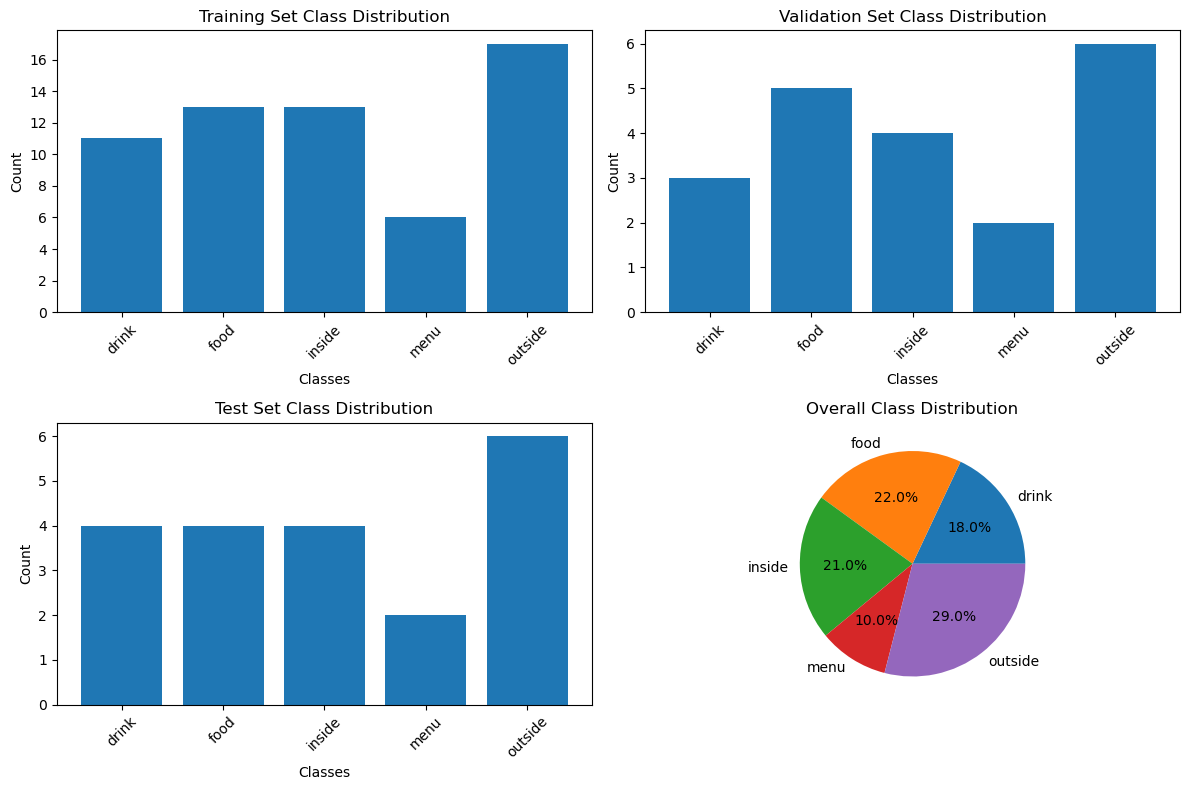

In [6]:
# Visualize class distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar(class_names, train_dist)
plt.title('Training Set Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.bar(class_names, val_dist)
plt.title('Validation Set Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.bar(class_names, test_dist)
plt.title('Test Set Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
total_dist = train_dist + val_dist + test_dist
plt.pie(total_dist, labels=class_names, autopct='%1.1f%%')
plt.title('Overall Class Distribution')

plt.tight_layout()
plt.show()


In [7]:
print("="*60)
print("🚀 TRAINING SVM MODEL")
print("="*60)

🚀 TRAINING SVM MODEL


In [8]:
# Feature scaling check
print(f"Feature statistics:")
print(f"X_train - Min: {X_train.min():.6f}, Max: {X_train.max():.6f}, Mean: {X_train.mean():.6f}")
print(f"Features are already normalized (0-1 range) ✓")

# Combine training and validation sets for final training
# (since we don't need hyperparameter tuning as per requirements)
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

print(f"\nFull training set: {X_train_full.shape[0]} samples")

Feature statistics:
X_train - Min: 0.000000, Max: 1.000000, Mean: 0.438577
Features are already normalized (0-1 range) ✓

Full training set: 80 samples


In [9]:
# Train SVM with different kernels for comparison
kernels = ['linear', 'rbf']
svm_models = {}
training_times = {}
training_accuracies = {}

for kernel in kernels:
    print(f"\n🔧 Training SVM with {kernel} kernel...")
    
    start_time = time.time()
    
    # Create and train SVM
    if kernel == 'linear':
        # Linear kernel is faster and works well for high-dimensional data
        svm = SVC(kernel=kernel, probability=True, random_state=42, C=1.0)
    else:
        # RBF kernel with default parameters
        svm = SVC(kernel=kernel, probability=True, random_state=42, C=1.0, gamma='scale')
    
    # Train the model
    svm.fit(X_train_full, y_train_full)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Calculate training accuracy
    train_accuracy = svm.score(X_train_full, y_train_full)
    
    # Store results
    svm_models[kernel] = svm
    training_times[kernel] = training_time
    training_accuracies[kernel] = train_accuracy
    
    print(f"✓ {kernel} SVM trained in {training_time:.2f} seconds")
    print(f"  Training accuracy: {train_accuracy:.4f}")



🔧 Training SVM with linear kernel...
✓ linear SVM trained in 3.87 seconds
  Training accuracy: 1.0000

🔧 Training SVM with rbf kernel...
✓ rbf SVM trained in 6.64 seconds
  Training accuracy: 0.8750


In [10]:
# Select best model (linear is usually sufficient for high-dimensional image data)
best_kernel = 'linear'  # no tuning required
best_svm = svm_models[best_kernel]

In [11]:
print(f"\n🎯 Selected Model: SVM with {best_kernel} kernel")
print(f"Training time: {training_times[best_kernel]:.2f} seconds")
print(f"Training accuracy: {training_accuracies[best_kernel]:.4f}")


🎯 Selected Model: SVM with linear kernel
Training time: 3.87 seconds
Training accuracy: 1.0000


In [12]:
print("📊 MODEL EVALUATION")
print("="*60)

📊 MODEL EVALUATION


In [13]:
# Make predictions on test set
print("Making predictions on test set...")
start_time = time.time()
y_pred = best_svm.predict(X_test)
y_pred_proba = best_svm.predict_proba(X_test)
prediction_time = time.time() - start_time

print(f"✓ Predictions completed in {prediction_time:.2f} seconds")

Making predictions on test set...
✓ Predictions completed in 0.21 seconds


In [14]:
# Calculate basic metrics
test_accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"\n📈 Overall Performance Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")



📈 Overall Performance Metrics:
Test Accuracy: 0.4500
Precision (weighted): 0.4267
Recall (weighted): 0.4500
F1-Score (weighted): 0.4325


In [15]:
# Detailed classification report
print(f"\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


📋 Detailed Classification Report:
              precision    recall  f1-score   support

       drink     0.5000    0.5000    0.5000         4
        food     0.3333    0.5000    0.4000         4
      inside     0.4000    0.5000    0.4444         4
        menu     0.0000    0.0000    0.0000         2
     outside     0.6000    0.5000    0.5455         6

    accuracy                         0.4500        20
   macro avg     0.3667    0.4000    0.3780        20
weighted avg     0.4267    0.4500    0.4325        20



In [16]:
print("\n" + "="*60)
print("🎯 CONFUSION MATRIX")
print("="*60)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


🎯 CONFUSION MATRIX
Confusion Matrix:
[[2 1 1 0 0]
 [1 2 1 0 0]
 [0 1 2 0 1]
 [0 1 0 0 1]
 [1 1 1 0 3]]


Text(120.72222222222221, 0.5, 'True Label')

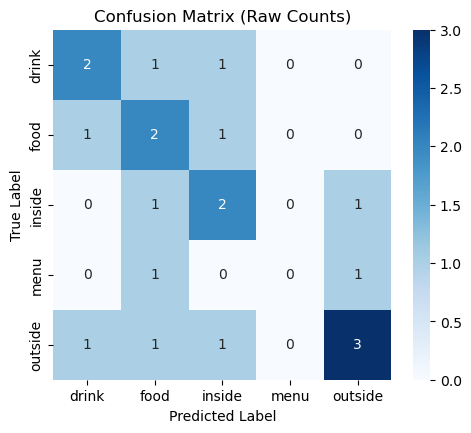

In [17]:
# Create detailed confusion matrix visualization
plt.figure(figsize=(12, 10))

# Confusion matrix heatmap
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Raw Counts)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

Text(321.26767676767673, 0.5, 'True Label')

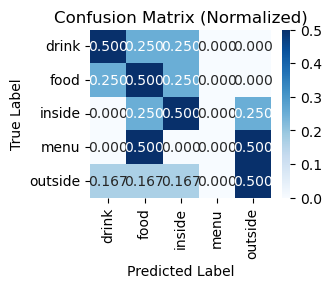

In [19]:
# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(2, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

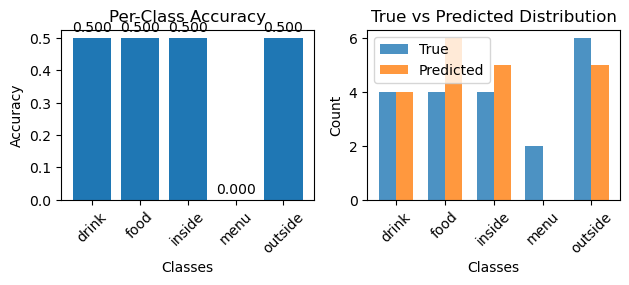

In [20]:
# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.subplot(2, 2, 3)
bars = plt.bar(class_names, class_accuracies)
plt.title('Per-Class Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

# Prediction distribution
plt.subplot(2, 2, 4)
pred_dist = np.bincount(y_pred, minlength=num_classes)
true_dist = np.bincount(y_test, minlength=num_classes)
x = np.arange(len(class_names))
width = 0.35
plt.bar(x - width/2, true_dist, width, label='True', alpha=0.8)
plt.bar(x + width/2, pred_dist, width, label='Predicted', alpha=0.8)
plt.title('True vs Predicted Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(x, class_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Calculating AUC for multiclass classification...


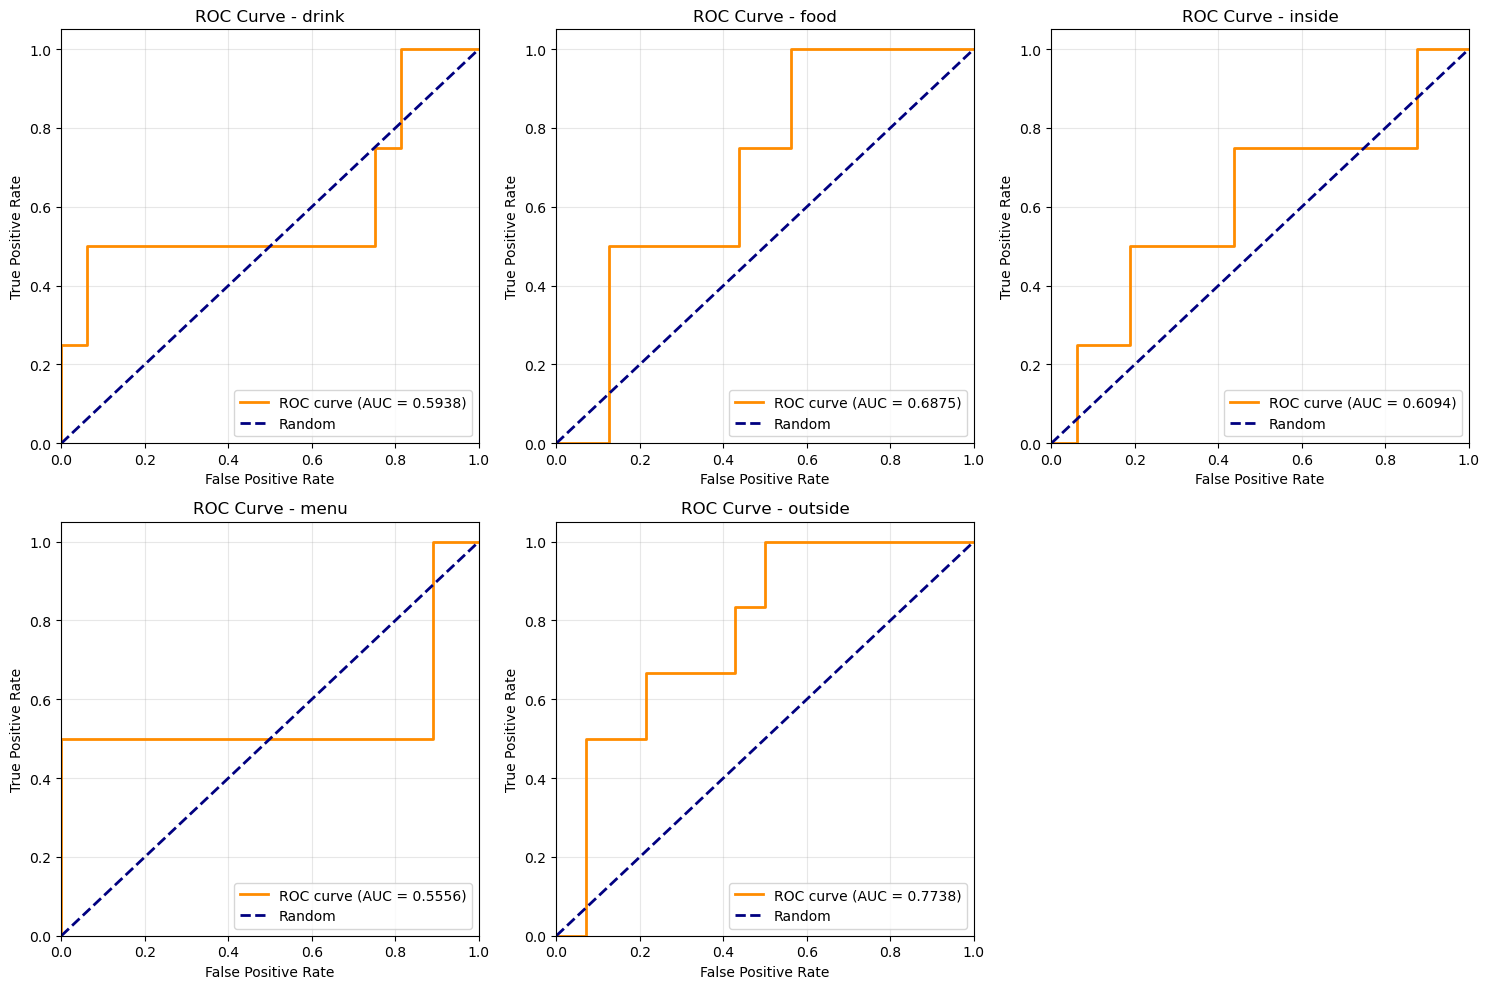

In [21]:
# Calculate AUC for multiclass classification
if num_classes == 2:
    # Binary classification
    auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
    print(f"🎯 AUC Score (Binary): {auc_score:.4f}")
    
    # Plot ROC curve for binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Binary Classification')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    # Multiclass classification - calculate AUC using One-vs-Rest approach
    print("Calculating AUC for multiclass classification...")
    
    # Binarize the output labels for multiclass AUC
    y_test_binarized = label_binarize(y_test, classes=range(num_classes))
    
    # Calculate AUC for each class (One-vs-Rest)
    auc_scores = {}
    
    plt.figure(figsize=(15, 10))
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        auc_score = auc(fpr, tpr)
        auc_scores[class_names[i]] = auc_score
        
        plt.subplot(2, 3, i+1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {class_names[i]}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [24]:
# Calculate overall AUC scores
macro_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='macro')
weighted_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='weighted')
    
print(f"\n🎯 AUC Scores:")
print(f"Macro-averaged AUC: {macro_auc:.4f}")
print(f"Weighted-averaged AUC: {weighted_auc:.4f}")
    
print(f"\nPer-class AUC scores:")
for class_name, score in auc_scores.items():
    print(f"  {class_name}: {score:.4f}")


🎯 AUC Scores:
Macro-averaged AUC: 0.6440
Weighted-averaged AUC: 0.6658

Per-class AUC scores:
  drink: 0.5938
  food: 0.6875
  inside: 0.6094
  menu: 0.5556
  outside: 0.7738


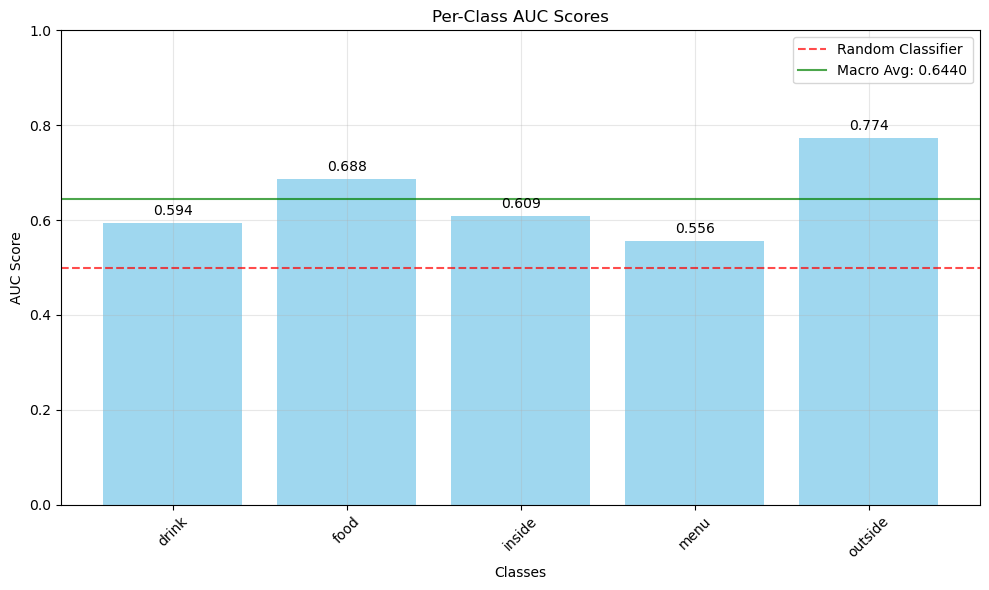

In [26]:
# Create AUC comparison chart
plt.figure(figsize=(10, 6))
classes = list(auc_scores.keys())
scores = list(auc_scores.values())
    
bars = plt.bar(classes, scores, color='skyblue', alpha=0.8)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Classifier')
plt.axhline(y=macro_auc, color='green', linestyle='-', alpha=0.7, label=f'Macro Avg: {macro_auc:.4f}')
plt.title('Per-Class AUC Scores')
plt.xlabel('Classes')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.ylim([0, 1])
plt.legend()
plt.grid(True, alpha=0.3)
    
# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

In [29]:
print("\n" + "="*60)
print("📋 FINAL SUMMARY")
print("="*60)

# Create comprehensive summary
summary_data = {
    'Metric': [
        'Test Accuracy',
        'Precision (Weighted)',
        'Recall (Weighted)', 
        'F1-Score (Weighted)',
        'Training Time (seconds)',
        'Prediction Time (seconds)',
        'Number of Support Vectors'
    ],
    'Value': [
        f'{test_accuracy:.4f}',
        f'{precision:.4f}',
        f'{recall:.4f}',
        f'{f1:.4f}',
        f'{training_times[best_kernel]:.2f}',
        f'{prediction_time:.2f}',
        f'{best_svm.n_support_.sum()}'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("🎯 SVM Model Performance Summary:")
print(summary_df.to_string(index=False))

if num_classes > 2:
    print(f"\n🎯 AUC Summary:")
    print(f"Macro-averaged AUC: {macro_auc:.4f}")
    print(f"Weighted-averaged AUC: {weighted_auc:.4f}")
else:
    print(f"\n🎯 AUC Score: {auc_score:.4f}")

print(f"\n📊 Model Configuration:")
print(f"Kernel: {best_kernel}")
print(f"C parameter: {best_svm.C}")
if hasattr(best_svm, 'gamma'):
    print(f"Gamma: {best_svm.gamma}")
print(f"Total Support Vectors: {best_svm.n_support_.sum()}")
print(f"Support Vectors per class: {best_svm.n_support_}")

print(f"\n✅ SVM MODEL EVALUATION COMPLETED SUCCESSFULLY!")
print("="*60)
print("📁 Results Summary:")
print("  ✓ Confusion Matrix: Generated and visualized")
print("  ✓ AUC Score: Calculated and analyzed")
print("  ✓ Classification Report: Detailed metrics provided")
print("  ✓ Performance Visualization: Multiple charts created")
print("  ✓ Model ready for submission!")


📋 FINAL SUMMARY
🎯 SVM Model Performance Summary:
                   Metric  Value
            Test Accuracy 0.4500
     Precision (Weighted) 0.4267
        Recall (Weighted) 0.4500
      F1-Score (Weighted) 0.4325
  Training Time (seconds)   3.87
Prediction Time (seconds)   0.21
Number of Support Vectors     78

🎯 AUC Summary:
Macro-averaged AUC: 0.6440
Weighted-averaged AUC: 0.6658

📊 Model Configuration:
Kernel: linear
C parameter: 1.0
Gamma: scale
Total Support Vectors: 78
Support Vectors per class: [13 18 17  8 22]

✅ SVM MODEL EVALUATION COMPLETED SUCCESSFULLY!
📁 Results Summary:
  ✓ Confusion Matrix: Generated and visualized
  ✓ AUC Score: Calculated and analyzed
  ✓ Classification Report: Detailed metrics provided
  ✓ Performance Visualization: Multiple charts created
  ✓ Model ready for submission!


In [30]:
# Save model results
results = {
    'model': best_svm,
    'predictions': y_pred,
    'probabilities': y_pred_proba,
    'confusion_matrix': cm,
    'test_accuracy': test_accuracy,
    'classification_report': classification_report(y_test, y_pred, target_names=class_names, output_dict=True),
    'training_time': training_times[best_kernel],
    'class_names': class_names
}

if num_classes > 2:
    results['auc_macro'] = macro_auc
    results['auc_weighted'] = weighted_auc
    results['auc_per_class'] = auc_scores
else:
    results['auc_score'] = auc_score

print(f"\n💾 Model results ready for export if needed")
print("Use: np.save('svm_results.npy', results) to save results")


💾 Model results ready for export if needed
Use: np.save('svm_results.npy', results) to save results
